In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

Change instantiation to random product feature instead

# Imports

In [2]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "title_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

product_nodes = torch.rand(product_nodes.shape)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [ ]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(383703, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Add hook 

This will help track the outputs

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 4.5493, Val Loss: 15.2459, best model epoch: 5
Epoch: 200, Train Loss: 2.1144, Val Loss: 10.2245, best model epoch: 200
Epoch: 300, Train Loss: 1.9875, Val Loss: 10.2619, best model epoch: 279
Epoch: 400, Train Loss: 1.5794, Val Loss: 10.4155, best model epoch: 308
Epoch: 500, Train Loss: 1.6736, Val Loss: 8.7580, best model epoch: 495
Epoch: 600, Train Loss: 1.3658, Val Loss: 9.2510, best model epoch: 495
Epoch: 700, Train Loss: 1.3140, Val Loss: 9.5863, best model epoch: 495
Epoch: 800, Train Loss: 1.1108, Val Loss: 9.9704, best model epoch: 495
Epoch: 900, Train Loss: 1.1971, Val Loss: 10.2864, best model epoch: 495
Epoch: 1000, Train Loss: 0.9602, Val Loss: 9.9059, best model epoch: 495


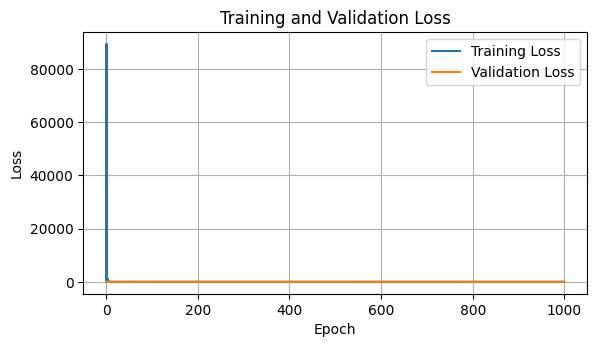

In [18]:
plot_train_val_loss(train_loss, test_loss)

# Test

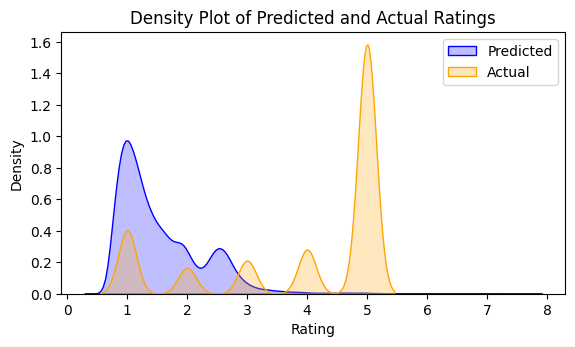

Test loss: 8.4998


In [19]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Recomendations 

In [20]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [21]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: 25 Pieces Christmas Hair Scrunchies Soft Elastic Hair Bands Plaid Snowflake Hair Scrunchy Christmas Elastics Bobbles for Xmas Hair Accessories
Product 2: CABLE4U BeeKind Body Care Box Sets, 15.5oz
Product 3: Regent Park Naturals Pierogi on a Rope | Novelty Soap on a Rope | Poland Theme | Polish Gift | 3.5oz
Product 4: Moresoo 16 Inch Kinky Curly Dark Brown and Light Brown Hifhlights Clip in Human Hair Extensions 7A Curly Clip ins Human Hair Brazilian Hair Extension for Women
Product 5: Mugler Cologne By Thierry Mugler Gift Set -- 3.4 Oz EDT Spray & 4.4 Oz Douche Tonique Corps & Cheveux
Product 6: Namecute Black Curly Wigs Long Synthetic Fullcap Wig for Women (#1B Color)
Product 7: Silicone Back Scrubber for Shower for Men Women, jiebor 2Pcs Body Scrubber,Back Brush Long Handle for Shower,Back Washer for Shower,Back Cleaner for Shower,Bath Back Scrubber 30inch
Product 8: Kreepsville 666 Mini Bone Hair Slides White Horror Halloween
Product 9: WILTON Mini 8 x 5-Inch Cookie Pans

In [22]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [23]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: 25 Pieces Christmas Hair Scrunchies Soft Elastic Hair Bands Plaid Snowflake Hair Scrunchy Christmas Elastics Bobbles for Xmas Hair Accessories
Product 2: CABLE4U BeeKind Body Care Box Sets, 15.5oz
Product 3: Regent Park Naturals Pierogi on a Rope | Novelty Soap on a Rope | Poland Theme | Polish Gift | 3.5oz
Product 4: Moresoo 16 Inch Kinky Curly Dark Brown and Light Brown Hifhlights Clip in Human Hair Extensions 7A Curly Clip ins Human Hair Brazilian Hair Extension for Women
Product 5: Mugler Cologne By Thierry Mugler Gift Set -- 3.4 Oz EDT Spray & 4.4 Oz Douche Tonique Corps & Cheveux
Product 6: Namecute Black Curly Wigs Long Synthetic Fullcap Wig for Women (#1B Color)
Product 7: Silicone Back Scrubber for Shower for Men Women, jiebor 2Pcs Body Scrubber,Back Brush Long Handle for Shower,Back Washer for Shower,Back Cleaner for Shower,Bath Back Scrubber 30inch
Product 8: Kreepsville 666 Mini Bone Hair Slides White Horror Halloween
Product 9: WILTON Mini 8 x 5-Inch Cookie Pans

In [24]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [25]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: 25 Pieces Christmas Hair Scrunchies Soft Elastic Hair Bands Plaid Snowflake Hair Scrunchy Christmas Elastics Bobbles for Xmas Hair Accessories
Product 2: CABLE4U BeeKind Body Care Box Sets, 15.5oz
Product 3: Regent Park Naturals Pierogi on a Rope | Novelty Soap on a Rope | Poland Theme | Polish Gift | 3.5oz
Product 4: Moresoo 16 Inch Kinky Curly Dark Brown and Light Brown Hifhlights Clip in Human Hair Extensions 7A Curly Clip ins Human Hair Brazilian Hair Extension for Women
Product 5: Mugler Cologne By Thierry Mugler Gift Set -- 3.4 Oz EDT Spray & 4.4 Oz Douche Tonique Corps & Cheveux
Product 6: Namecute Black Curly Wigs Long Synthetic Fullcap Wig for Women (#1B Color)
Product 7: Silicone Back Scrubber for Shower for Men Women, jiebor 2Pcs Body Scrubber,Back Brush Long Handle for Shower,Back Washer for Shower,Back Cleaner for Shower,Bath Back Scrubber 30inch
Product 8: Kreepsville 666 Mini Bone Hair Slides White Horror Halloween
Product 9: WILTON Mini 8 x 5-Inch Cookie Pans

In [26]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [27]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: 25 Pieces Christmas Hair Scrunchies Soft Elastic Hair Bands Plaid Snowflake Hair Scrunchy Christmas Elastics Bobbles for Xmas Hair Accessories
Product 2: CABLE4U BeeKind Body Care Box Sets, 15.5oz
Product 3: Regent Park Naturals Pierogi on a Rope | Novelty Soap on a Rope | Poland Theme | Polish Gift | 3.5oz
Product 4: Moresoo 16 Inch Kinky Curly Dark Brown and Light Brown Hifhlights Clip in Human Hair Extensions 7A Curly Clip ins Human Hair Brazilian Hair Extension for Women
Product 5: Mugler Cologne By Thierry Mugler Gift Set -- 3.4 Oz EDT Spray & 4.4 Oz Douche Tonique Corps & Cheveux
Product 6: Namecute Black Curly Wigs Long Synthetic Fullcap Wig for Women (#1B Color)
Product 7: Silicone Back Scrubber for Shower for Men Women, jiebor 2Pcs Body Scrubber,Back Brush Long Handle for Shower,Back Washer for Shower,Back Cleaner for Shower,Bath Back Scrubber 30inch
Product 8: Kreepsville 666 Mini Bone Hair Slides White Horror Halloween
Product 9: WILTON Mini 8 x 5-Inch Cookie Pans

# Analysing predictions

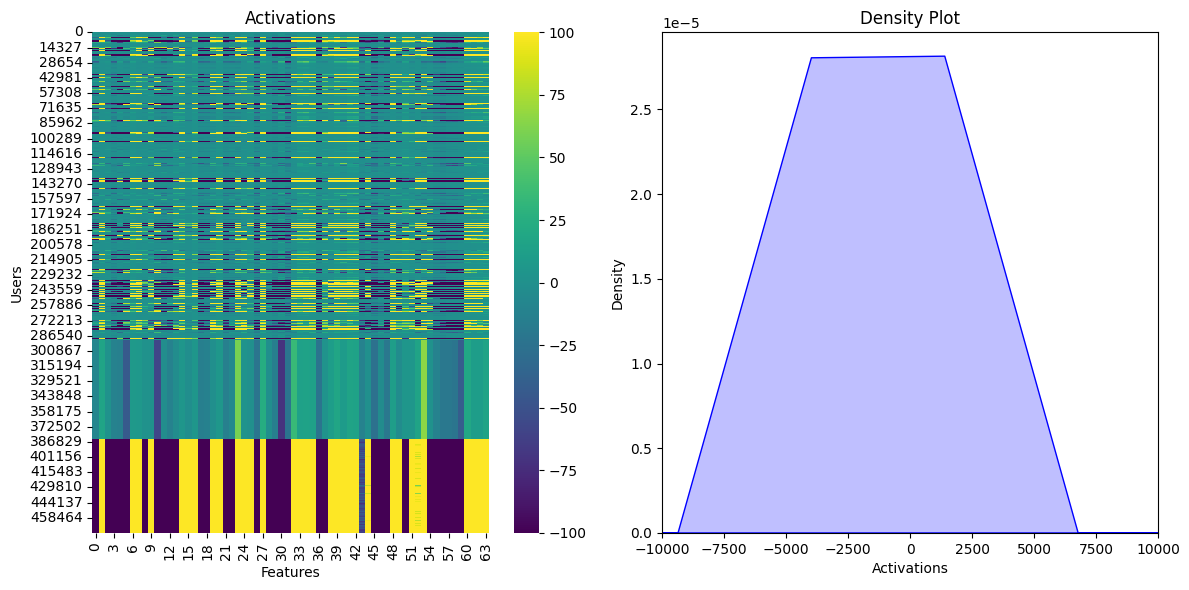

In [28]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

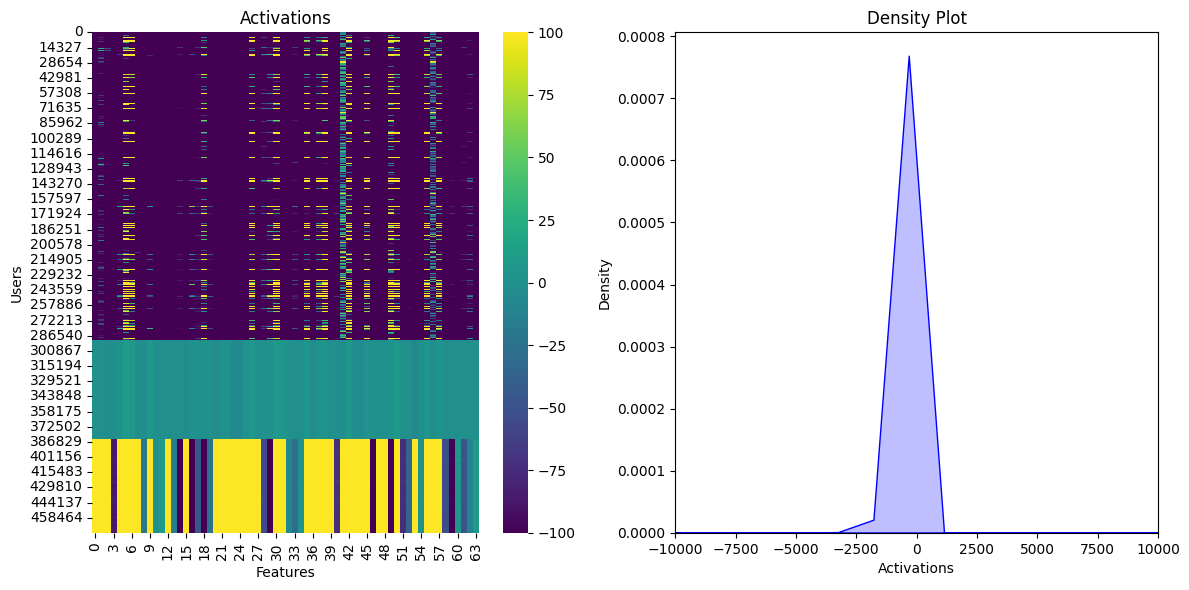

In [29]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

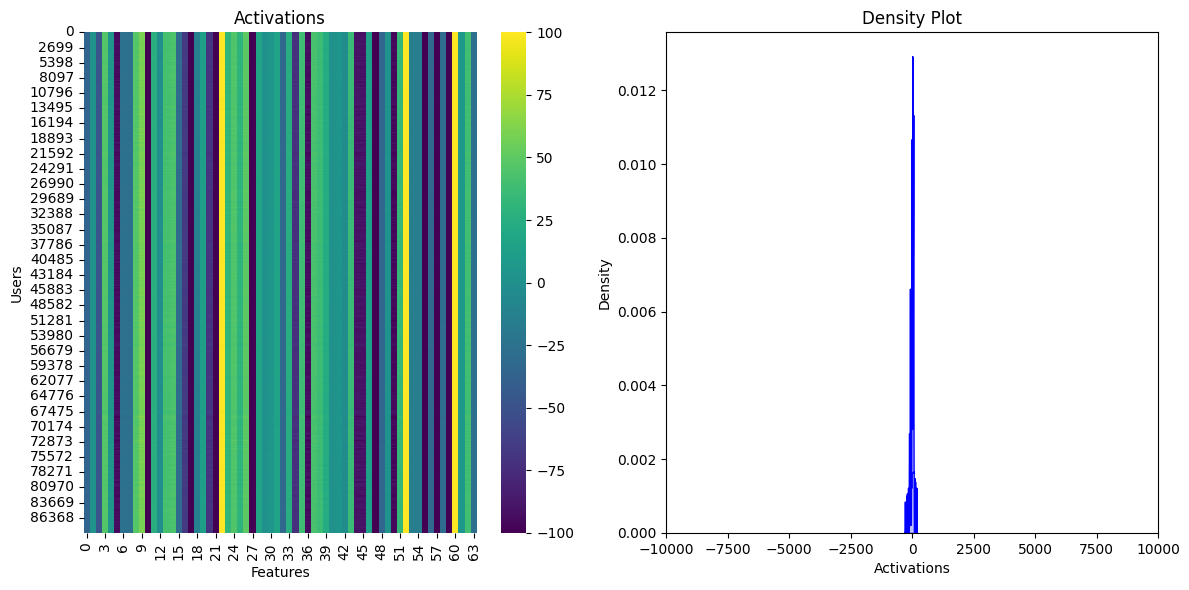

In [30]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

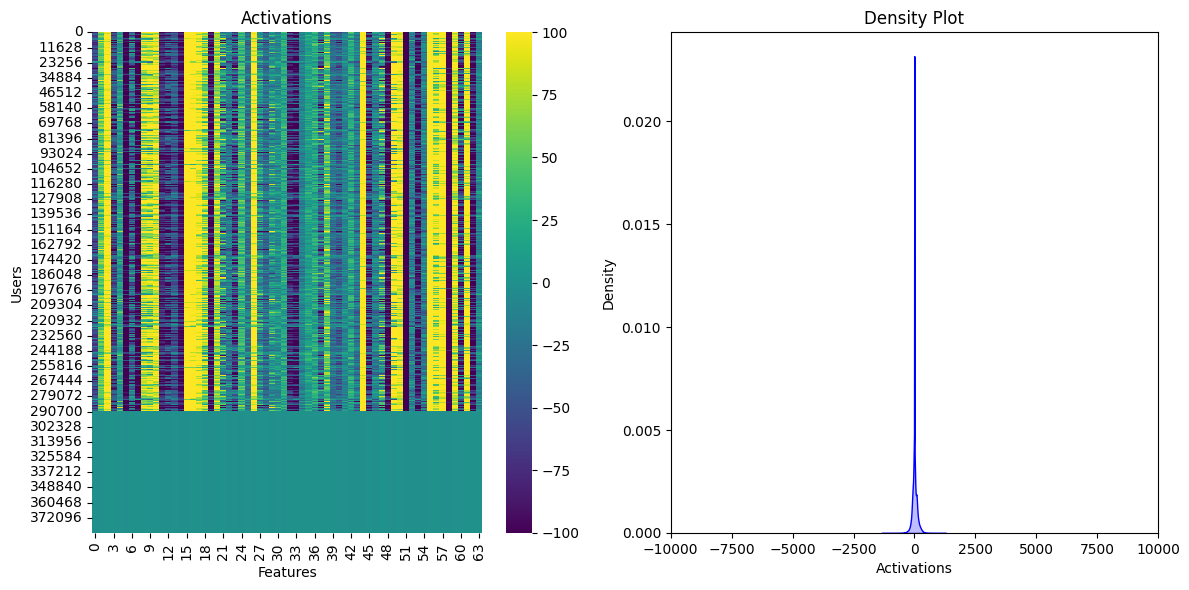

In [31]:

# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)